# Audio Predictor Evaluation
This notebook helps to see how audio predictor synthesize voice using existing phonemes

In [1]:
# Base
import itertools
from glob import glob
from tqdm import tqdm
import math
import textgrid
import random
import matplotlib.pyplot as plt

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import DistributedSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter
from IPython.display import Audio, display
from vocos import Vocos

# Local
from train.misc import plot_specgram, plot_waveform
from supervoice_hybrid import SupervoiceVariant2, SentencePieceTextTokenizer
from supervoice_hybrid.audio import spectogram, load_mono_audio
from supervoice_hybrid.config import config

/home/steve/miniconda3/envs/gym/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/steve/miniconda3/envs/gym/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


In [2]:
device = "cuda"

# Vocoder
vocoder = torch.hub.load(repo_or_dir='ex3ndr/supervoice-vocoder', model='bigvsan')
vocoder = vocoder.to(device)
def do_vocoder(src):
    with torch.no_grad():
        return vocoder.generate(src)

# Tokenizer
tokenizer = SentencePieceTextTokenizer("./tokenizer_text.model")
phoneme_duration = config.audio.hop_size / config.audio.sample_rate

Using cache found in /home/steve/.cache/torch/hub/ex3ndr_supervoice-vocoder_master


In [3]:
def audio_denormalize(src):
    return (src * config.audio.norm_std) + config.audio.norm_mean

def audio_normalize(src):
    return (src - config.audio.norm_mean) / config.audio.norm_std

def do_spectogram(src):
    return spectogram(src, config.audio.n_fft, config.audio.n_mels, config.audio.hop_size, config.audio.win_size, config.audio.mel_norm, config.audio.mel_scale, config.audio.sample_rate)

def empty_tokens(size):
    return torch.zeros((size)).long().to(device)

def empty_mask(size):
    return torch.ones((size)).bool().to(device)

### Load Model

In [4]:
model = SupervoiceVariant2()
model = model.to(device)
checkpoint = torch.load(f'./output/var2-1.pt', map_location="cpu", weights_only=True)
model.load_state_dict(checkpoint['model'])
model.eval()
print("Predictor at ", checkpoint['step'])

Predictor at  99000


### Load audio with phonemes
This loads sample audio that we would be able to use to compare with synthesized one

Source audio


Re-synth audio


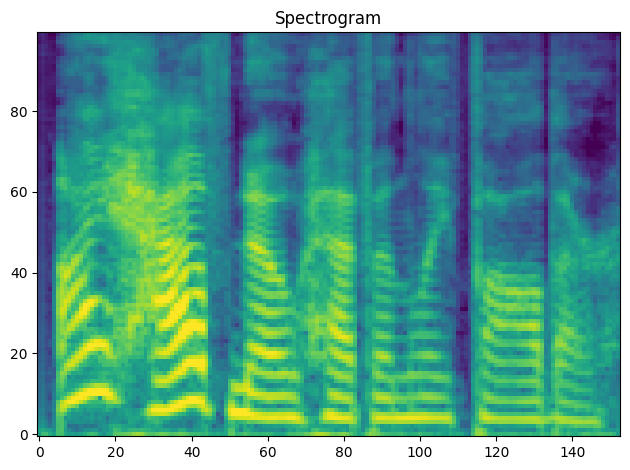

In [5]:
# Load audio
sample_audio = "./external_datasets/libritts-r/test-clean/1221/135766/1221_135766_000025_000001.wav"
sample_text = "I have no Heavenly Father!"
waveform = load_mono_audio(sample_audio, sample_rate = config.audio.sample_rate)
tokens = tokenizer.encode(sample_text)
spec = do_spectogram(waveform)
spec = spec.to(device)
tokens = tokens.to(device)

# Source audio
print("Source audio")
display(Audio(data=waveform, rate=config.audio.sample_rate))
print("Re-synth audio")
display(Audio(data=do_vocoder(spec).cpu(), rate=config.audio.sample_rate))
plot_specgram(spec.cpu())

In [6]:
# # Load conditioning audio
# cond_index = 2107
# # filename = "external_datasets/libritts-r-clean-100/60/121082/60_121082_000004_000001.wav
# cond_waveform = load_mono_audio(files[cond_index], sample_rate = config.audio.sample_rate)
# cond_style = torch.load(styles[cond_index])
# cond_spec = do_spectogram(cond_waveform)
# cond_tokens, _, cond_token_styles = extract_tokens(tg[cond_index], cond_style, cond_spec, True)
# cond_spec = cond_spec.to(device)
# cond_tokens = cond_tokens.to(device)
# cond_token_styles = cond_token_styles.to(device)
# cond_spec = cond_spec[:, :len(cond_tokens)]
# assert len(cond_tokens) == cond_spec.shape[1]

# # Source audio
# print("Conditioning audio")
# display(Audio(data=cond_waveform, rate=config.audio.sample_rate))
# plot_specgram(cond_spec.cpu())

### Synthesize unconditioned voice

Synthesized without any input


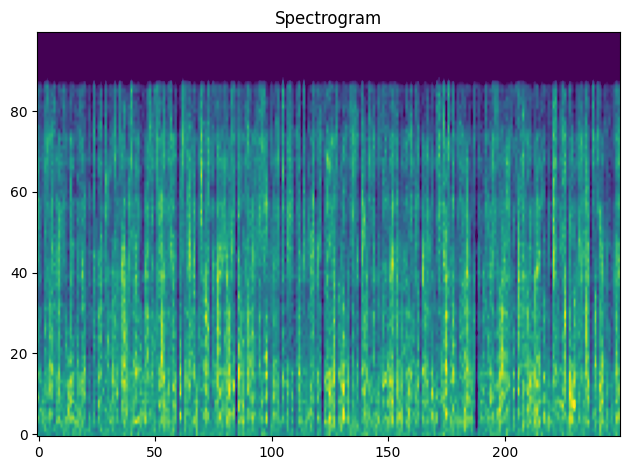

In [7]:
with torch.no_grad():
    sample_duration = 250
    sample = model.sample(
        tokens = torch.zeros(sample_duration).long().to(device),
        audio = torch.zeros((sample_duration, config.audio.n_mels)).to(device),
        interval = [0, sample_duration],
        steps = 16
    )
    sample = audio_denormalize(sample)

# Resynth
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
print("Synthesized without any input")
display(Audio(data=resynth, rate=config.audio.sample_rate))
plot_specgram(sample.T.cpu())    

# Display trajectory
# for i in reversed(range(len(trajectory))):
#     plot_specgram(trajectory[i].transpose(1,0).cpu())    

# Synthesize voice from text
This synthesizes random voice from existing text

Source of phonemes


Synthesized with phonemes provided


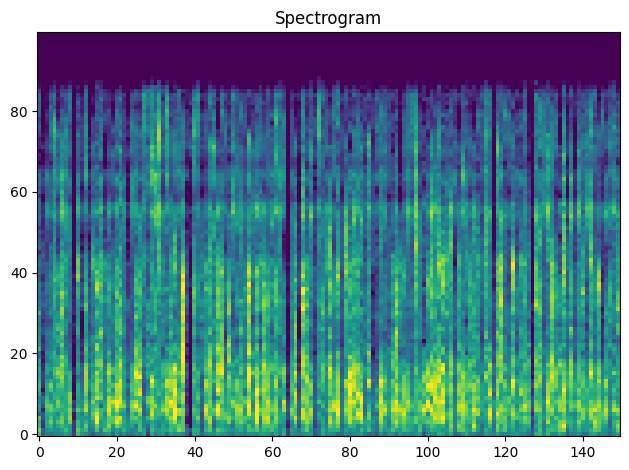

In [8]:
with torch.no_grad():
    sample_duration = 150
    sample = model.sample(
        tokens = tokens.to(device),
        audio = torch.zeros((sample_duration, config.audio.n_mels)).to(device),
        interval = [0, sample_duration],
        steps = 16
    )
    sample = audio_denormalize(sample)

# Resynth
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
print("Source of phonemes")
display(Audio(data=waveform, rate=config.audio.sample_rate))
print("Synthesized with phonemes provided")
display(Audio(data=resynth, rate=config.audio.sample_rate))
plot_specgram(sample.transpose(1,0).cpu())
# Display trajectory
# for i in reversed(range(len(trajectory))):
#     plot_specgram(trajectory[i].transpose(1,0).cpu())    

In [9]:
with torch.no_grad():

    # Params
    s_steps = 8
    s_tokens = tokens
    s_tokens_style = torch.zeros(len(tokens)).long().to(device)
    s_audio = torch.zeros((len(tokens), config.audio.n_mels)).to(device)
    s_mask = empty_mask(len(tokens))

    # Synthesize
    sample, trajectory = model.sample(tokens = s_tokens, tokens_style = s_tokens_style, audio = s_audio, mask = s_mask, steps = s_steps, alpha = 0.5)
    sample = audio_denormalize(sample)
    trajectory = audio_denormalize(trajectory)

# Resynth
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
print("Source of phonemes")
display(Audio(data=waveform, rate=config.audio.sample_rate))
print("Synthesized with phonemes provided without styles")
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
# for i in reversed(range(len(trajectory))):
#     plot_specgram(trajectory[i].transpose(1,0).cpu())    

TypeError: SupervoiceVariant2.sample() got an unexpected keyword argument 'tokens_style'

### Restore segment
Cut part of the audio and re-generate segment

In [ ]:
# with torch.no_grad():

#     # Params
#     s_steps = 4
#     s_tokens = empty_tokens(len(tokens))
#     s_audio = audio_normalize(spec.transpose(1,0))

#     # Mask
#     seq_len = len(tokens)
#     s_mask = torch.zeros((seq_len)).bool().to(device)
#     s_mask[math.floor(seq_len * 0.2): math.floor(seq_len * 0.6)] = True
#     s_audio = drop_using_mask(s_audio, 0, s_mask)

#     # Restore audio
#     sample, trajectory = model.sample(tokens = s_tokens, audio = s_audio, mask = s_mask, steps = s_steps)
#     sample = audio_denormalize(sample)
#     trajectory = audio_denormalize(trajectory)

# # Resynth
# resynth = do_vocoder(sample.transpose(1,0).to(device)).detach().cpu()

# # Display audio
# print("Source")
# display(Audio(data=waveform, rate=config.audio.sample_rate))
# print("Restored segment without tokens provided")
# display(Audio(data=resynth, rate=config.audio.sample_rate))

# # Display trajectory
# plot_specgram(sample.transpose(1,0).cpu())
# # for i in reversed(range(len(trajectory))):
# #     plot_specgram(trajectory[i].transpose(1,0).cpu())    

In [ ]:
with torch.no_grad():

    # Params
    s_steps = 4
    s_tokens = tokens
    s_tokens_style = token_styles + 1
    s_audio = audio_normalize(spec.transpose(1,0))

    # Mask
    seq_len = len(tokens)
    s_mask = torch.zeros((seq_len)).bool().to(device)
    s_mask[math.floor(seq_len * 0.2): math.floor(seq_len * 0.6)] = True
    s_audio = drop_using_mask(s_audio, 0, s_mask)

    # Restore audio
    sample, trajectory = model.sample(tokens = s_tokens, tokens_style = s_tokens_style, audio = s_audio, mask = s_mask, steps = s_steps)
    sample = audio_denormalize(sample) * 1.2
    trajectory = audio_denormalize(trajectory)

# Resynth
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
print("Source")
display(Audio(data=waveform, rate=config.audio.sample_rate))
print("Restored segment with tokens provided")
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
plot_specgram(sample.transpose(1,0).cpu())
# for i in reversed(range(len(trajectory))):
#     plot_specgram(trajectory[i].transpose(1,0).cpu())    

### Conditioned TTS

In [ ]:
def conditioned_tts(tokens, steps = 8, alpha = 0.5):
    with torch.no_grad():

        # Create tokens
        s_audio = audio_normalize(torch.cat([cond_spec.transpose(1,0), torch.zeros(len(tokens) + 2, config.audio.n_mels, device=device)]))
        s_tokens = torch.cat([
            torch.tensor([tokenizer.begin_token_id], device=device), 
            cond_tokens[1:], 
            tokens, 
            torch.tensor([tokenizer.silence_token_id, tokenizer.end_token_id], device=device)])
        s_tokens_style = torch.cat([
            torch.tensor([0], device=device), 
            cond_token_styles[1:] + 1, 
            token_styles + 1, 
            torch.tensor([0, 0], device=device)])

        # Create a mask
        s_mask = torch.zeros((len(cond_tokens) + len(tokens) + 2)).bool().to(device)
        s_mask[len(cond_tokens):len(s_mask)] = True

        # Restore audio
        sample, trajectory = model.sample(tokens = s_tokens, tokens_style = s_tokens_style, audio = s_audio, mask = s_mask, steps = s_steps, alpha = alpha)
        sample = audio_denormalize(sample)
        trajectory = audio_denormalize(trajectory)
        sample = sample[len(cond_tokens):-2] * 1.2
        trajectory = trajectory[:,len(cond_tokens):]
        
        return sample, trajectory

sample, trajectory = conditioned_tts(tokens)

# Resynth
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
print("Source audio of phonemes and durations")
display(Audio(data=waveform, rate=config.audio.sample_rate))
print("Synthesized voice")
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
# for i in reversed(range(len(trajectory))):
#     plot_specgram(trajectory[i].transpose(1,0).cpu())    

### Variativity

In [ ]:
# for i in range(10):
#     with torch.no_grad():
#         sample, trajectory = model.sample(
#             tokens = tokens, 
#             audio = torch.zeros((len(tokens), config.audio.n_mels)).to(device),  # Empty source audio
#             mask = torch.ones((len(tokens))).bool().to(device), # Mask everything
#             steps = 4
#         )
#         sample = audio_denormalize(sample) * 1.1
#         resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)
#         display(Audio(data=resynth, rate=config.audio.sample_rate))
#         # plot_specgram(sample.transpose(1,0).cpu())    

# # Resynth
# # resynth = generator(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# # # Display audio
# # display(Audio(data=waveform, rate=config.audio.sample_rate))
# # display(Audio(data=resynth, rate=config.audio.sample_rate))

# # # Display trajectory
# # for i in reversed(range(len(trajectory))):
# #     plot_specgram(trajectory[i].transpose(1,0).cpu())    

In [ ]:
eval = phonemizator("I'm Sorry Dave, I'm Afraid I Can't Do That.", max_new_tokens = 1024)
speedup = 1.1
eval = [(char.replace('•', '<SIL>'), max(1, duration)) for char, duration in eval]
print(eval)
eval = [char for char, duration in eval for _ in range(round(duration * speedup))]

# with torch.no_grad():

#     # Params
#     s_steps = 32
#     s_tokens = torch.cat([torch.tensor([tokenizer.begin_token_id]), tokenizer(eval), torch.tensor([tokenizer.end_token_id])])
#     s_tokens = s_tokens.to(device)
#     s_audio = torch.zeros((len(s_tokens), config.audio.n_mels)).to(device)
#     s_mask = empty_mask(len(s_tokens)).to(device)

#     # Synthesize
#     sample, trajectory = model.sample(tokens = s_tokens, audio = s_audio, mask = s_mask, steps = s_steps, alpha = 0.5)
#     sample = audio_denormalize(sample) * 1.1
#     trajectory = audio_denormalize(trajectory)

sample, trajectory = conditioned_tts(tokenizer(eval).to(device), steps=4)

# Resynth
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
print("Synthesized sound")
display(Audio(data=resynth, rate=config.audio.sample_rate))

In [ ]:
import matplotlib.pyplot as plt
import pyworld as pw
import torchaudio
def load_mono_audio(src, sample_rate, device=None):

    # Load audio
    audio, sr = torchaudio.load(src)

    # Move to device
    if device is not None:
        audio = audio.to(device)

    # Resample
    if sr != sample_rate:
        audio = resampler(sr, sample_rate, device)(audio)
        sr = sample_rate

    # Convert to mono
    if audio.shape[0] > 1:
        audio = audio.mean(dim=0, keepdim=True)

    # Convert to single dimension
    audio = audio[0]

    return audio
    
wf = load_mono_audio("./datasets/libritts-prepared/00000012/00001341.wav", sample_rate = config.audio.sample_rate)

sp = do_spectogram(wf)
f0, t = pw.dio(wf.squeeze(0).numpy().astype('double'), 24000, frame_period=1000 * 256/24000)
display(Audio(data=wf, rate=config.audio.sample_rate))
_, axis = plt.subplots(1, 1, figsize=(20, 10))
axis.imshow(sp.cpu(), cmap="viridis", vmin=-10, vmax=0, origin="lower", aspect="auto")
axis.set_title("Spectogram")
axis.plot(f0, color="red")
# Draw annotations
for span in tg[210][0]:
    span_start = math.floor(span.minTime / phoneme_duration)
    span_end = math.floor(span.maxTime / phoneme_duration)
    axis.axvspan(span_start, span_end, facecolor="None", edgecolor="white")
    axis.annotate(span.mark, (span_start, 75), annotation_clip=True, color="white")
# for span in tg[210][1]:
#     span_start = math.floor(span.minTime / phoneme_duration)
#     span_end = math.floor(span.maxTime / phoneme_duration)
#     axis.annotate(span.mark, (span_start, 70), annotation_clip=True, color="white")
plt.tight_layout()

In [ ]:
plt.imshow(model.input_projection.weight.T[:,:600].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()